## Objective

This a bignner's guide to SVM. It aims to answer the following:

- When do we need to use Support Vector Machines?
- How to derive a Linear SVM model? What does Support Vectors mean?
- How to deal with data which is not 'linearly seperabale' with Kernel Trick?
- What are the advantages of SVM over Decision Trees and Logistic Regression?
- What are it's limitations ?

## Data

To explore SVM model we will look at a [diagnostic dataset for breast cancer ](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).

*You don't need to understand the data to learn basics of SVM. Think of the columns(features) as real numbers which have some correlation with the target class i.e. diagnosis*

 - ### Domain Background ([more info](http://dollar.biz.uiowa.edu/~street/research/hu_path95/hp95.pdf))
   This dataset was constructed by analzying images of breast masses of people 569 patients: 212 with cancer and 357 without cancer. Each data point corresponds to a patient and contains structural properties of the tumor and their diagnosis. These structural properties are modelled such that higher values are typically associated with malignant tumours.
   
   Diagnosis for the patients had been confirmed by additional surgical/lab procedures. **Our goal is to build a computer algorithm which can succesfully diagnose any patients in future, so as to (ideally)eliminate the need for expensive diagnostic proceedures.**
   
   *If you are curious, here are further details on how the data is obtained:* 
   
   *Images of fibrocystic breast masses are obtained using fine needle aspiration(FNA). Each patient has one FNA image. Each FNA image has several nuclei. Structural properties of each nuclei are calculated by a combination human observation and computer calculations. Nuclear size is given by radius and area. Shape is expressed by smoothness , concavity , compactness, concave points, symmetry and fractal dimension features. Both size and shape are expressed by perimeter. Nuclear texture is measured by finding the variance of gray scale intensities in pixels. The average, standard deviation and average of three worst values over all the nuclei for each feature is obtained. This gives 30 features for each patient.*


 - ### Description
   
   Here we will only look at the following columns of the data:
   
   - `patient_id` unique to a patient (integer valued) 
   - `diagnosis`  'M' for malignant and 'B' for benign
   - `radius_avg` average of radius of tumor (real valued)
   - `texture_avg` average of texture (real valued)
   - `permiter_avg` average of tumor perimeter (real valued)
   - `area_avg` average of tumor area
   - `smoothness_avg` average local variations in radius lengths
   - `compactness_avg` average(perimeter^2/area-1.0)
   - `concavity_avg` average severity of concave portions of the contour of tumor
   - `concave_points_avg` average number of concave portions of the contour
   - `symmetry_avg` average symmetry 
   - `fractal_dim_avg` average of fractal dimension ("coastline approximation" - 1)
   



In [5]:
import pandas as pd
bc_data = pd.read_csv("wdbc.csv")
print(bc_data.head())

# converting diagnosis to integer value for easier math
bc_data['diagnosis'] = bc_data['diagnosis'].replace(['M', 'B'], [1,0])

# some data cleaning to make it an ideal candidate for a simple SVM model.
bc_data = bc_data[(bc_data['radius_avg'] < 12) | (bc_data['radius_avg'] > 15)]

# dividing into two datasets for plotting purposes
malignant = bc_data[bc_data['diagnosis']==1 ]
benign = bc_data[bc_data['diagnosis'] == 0]

         ID diagnosis  radius_avg  texture_avg  perimeter_avg  area_avg  \
0    842517         M       20.57        17.77         132.90    1326.0   
1  84300903         M       19.69        21.25         130.00    1203.0   
2  84348301         M       11.42        20.38          77.58     386.1   
3  84358402         M       20.29        14.34         135.10    1297.0   
4    843786         M       12.45        15.70          82.57     477.1   

   smoothness_avg  compactness_avg  concavity_avg  concave_points_avg  \
0         0.08474          0.07864         0.0869             0.07017   
1         0.10960          0.15990         0.1974             0.12790   
2         0.14250          0.28390         0.2414             0.10520   
3         0.10030          0.13280         0.1980             0.10430   
4         0.12780          0.17000         0.1578             0.08089   

   symmetry_avg  fractal_dim_avg  
0        0.1812          0.05667  
1        0.2069          0.05999  
2    

### When do we need SVM?

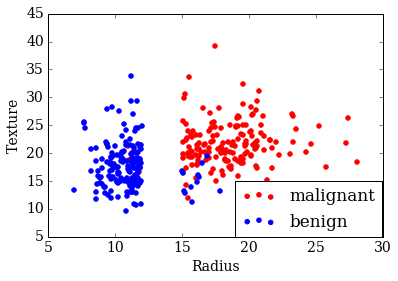

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=14)
plt.scatter(malignant['radius_avg'], malignant['texture_avg'],\
            color='r', label='malignant')
plt.scatter(benign['radius_avg'], benign['texture_avg'], 
            color='b', label='benign')
plt.xlabel('Radius')
plt.ylabel('Texture')
plt.legend(loc=(0.56,0))

As you can see from above figure, this data has a complex structure. It can be very hard to come up with a hypothesis which approximates the structure of such data (like we do in linear regression, where we assume data is linear with some noise added). Support Vector machines on the other hand pay little attention to the underlying structure. The aim here is to divided the domain of (radius, texture) into regions which contain only malignant or benign tumors. 

### How to derive a Linear SVM?

From above figure, notice that malignant and benign classes can be seperated easily by a line across the domain. Let's consider three lines $L_1$, $L_2$ and $L_3$. Which line would you pick?

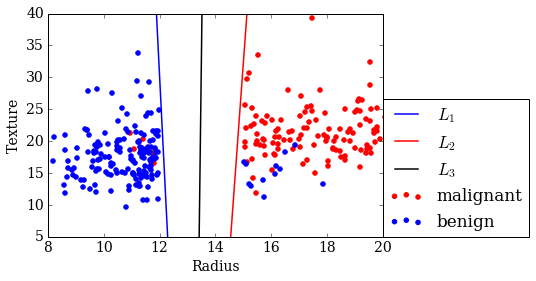

In [89]:
## Ignore this block of code.##

plt.scatter(malignant['radius_avg'], malignant['texture_avg'],\
            color='r', label='malignant')
plt.scatter(benign['radius_avg'], benign['texture_avg'], 
            color='b', label='benign')
# some rough manual math to get points to draw lines
rad1 = benign[benign['radius_avg'] < 12]['radius_avg'].idxmax()


# Points for Line 1 
p1 = benign[['radius_avg', 'texture_avg']].loc[rad1].tolist()
p2 = benign[['radius_avg', 'texture_avg']].loc[rad1].tolist()
p1[0] = p1[0] - 0.1
p1[1] = p1[1] + 15
p2[0] = p2[0] + 0.3
p2[1] = 5

plt.plot([p1[0], p2[0]], [p1[1],p2[1]],\
         linewidth=1.5, label=r'$L_1$')
plt.xlabel('Radius')
plt.ylabel('Texture')



# Points for Line 2
rad2 = malignant[malignant['radius_avg'] > 12]['radius_avg'].idxmin()
q1 = malignant[['radius_avg', 'texture_avg']].loc[rad2].tolist()
q2 = malignant[['radius_avg', 'texture_avg']].loc[rad2].tolist()
q1[0] = q1[0] + 0.1
q1[1] = q1[1] + 22
q2[0] = q2[0] - 0.5
q2[1] = 5
plt.plot([q1[0], q2[0]], [q1[1],q2[1]], color='r',\
         linewidth=1.5, label=r'$L_2$')

# Points for Line 3
s1 = [(p1[0]+q1[0])/2, p1[1]]
s2 = [(p2[0]+q2[0])/2, p2[1]]
plt.plot([s1[0], s2[0]], [s1[1],s2[1]],color='k',\
         linewidth=1.5, label=r"$L_3$")

plt.xlim([8,20])
plt.ylim([5,40])
plt.legend(loc=(1,0))


Suppose we pick Line $L_1$ to be our classifier line. Then all points to the right of $L_1$ will be classified as malignant and all point to the left will be benign. (*Note there are few points to the left and right of $L_1$ which will be misclassified, but these are very few and we will come back to them later.*). So $L_1$ does a great job of classifying the given dataset correctly. Same goes for $L_2$ and $L_3$.

But how well will these classifiers perform on unseen data? Afterall the goal here is to diagnose unclassified points. Suppose we choose to go with $L_1$. Now have to predict tumor with features $d_1$. (TODO:Insert figure here). $L_1$ will classify $d_1 = (12.5, 12.5)$ as malignant. But if we look at the figure, it's features are much closer to benign points. Similar argument can be made that $L_2$ will incorrectly classify $d_2 = (15,22.5)$  as benign. 

So even though both $L_1$ and $L_2$ have negligible error on training data, they generalize poorly to unseen data (i.e. have high error on testing data). 

What about $L_3$? It will correctly classify $d_1$ as benign and $d_2$ as malignant. Do you expect it's testing error to be higher or lower than $L_1$? 

What makes $L_3$ so special? Hint: Empty space on both sides.

### How do we find $L_3$

  Since we don't anything about the data in the empty region, we find $L_3$ by first finding $L_1$ and $L_2$.  Lines $L_1$ and $L_2$ are at the exact edges of the data. Goal of SVM is to find the lines $L1$ and $L2$ which are as far away from eachother as possible without intersecting the data. This is referred to as maximizing the margin. Then since it doesn't have any other information inside the margins, it places $L_3$ in the middle of $L_1$ and $L_2$, i.e. $L_3 = (L_1 + L_2)/2$. 
  
### Algorithm for finding $L_1$ and $L_2$